# Определение жанров музыкальных композиций

### Описание задачи:

Новому музыкальному сервису нужно разработать и внедрить систему автоматической классификации композиций по музыкальному жанру. 
<br>В распоряжении имеется база, состоящая из 1000 музыкальных композиций, распределенных по 10 папкам с названиями жанров (по 100 треков на жанр).

### Цель:

Выделить признаки и обучить нейросеть.

### Импорты:

In [ ]:
import librosa 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Audio

import os
import pandas as pd
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate, Dense, Dropout
from tensorflow.keras.utils import set_random_seed
           
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import zipfile
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # подключение Гугл Диска, где хранится датасет

Mounted at /content/drive


### Знакомство с данными

In [ ]:
# извлечение данных из архива базы треков на гугл диске

z = zipfile.ZipFile('/content/drive/MyDrive/python_study/audio/genres.zip', 'r')

z.extractall()

In [ ]:
# создадим список жанров из названий соответствующих папок

genres = os.listdir('/content/genres')
genres

['reggae',
 'jazz',
 'country',
 'hiphop',
 'rock',
 'metal',
 'classical',
 'disco',
 'blues',
 'pop']

In [ ]:
# проверим количество файлов в папках

!ls -laR genres | grep "^-" | wc
!ls -laR genres/pop | grep "^-" | wc

   1000    9000   60400
    100     900    5800


In [ ]:
# библиотека librosa загружает муз. композицию в качестве временного ряда (ts) -
# одномерного вектора и параметра sample_rate (sr) -количество семплов в секунду
# произведем тестовую загрузку и прослушивание случайной композиции

audio_path = '/content/genres/blues/blues.00005.au'
ts1, sr1 = librosa.load(audio_path)
print(type(ts1), type(sr1))
print(ts1.shape, sr1) 

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [ ]:
# загрузим для сравнения трек другого жанра с принципиально другим звучанием, например metal

ts2, sr2 = librosa.load('/content/genres/metal/metal.00025.au')
print(type(ts2), type(sr2))
print(ts2.shape, sr2) 

<class 'numpy.ndarray'> <class 'int'>
(661504,) 22050


In [ ]:
# плеер
Audio(data=ts1, rate=sr1)

In [ ]:
Audio(data=ts2, rate=sr2)

In [ ]:
ts1[:10]

array([-0.02429199, -0.02975464, -0.00961304,  0.00091553,  0.00634766,
        0.01657104,  0.02920532,  0.03866577,  0.04458618,  0.04425049],
      dtype=float32)

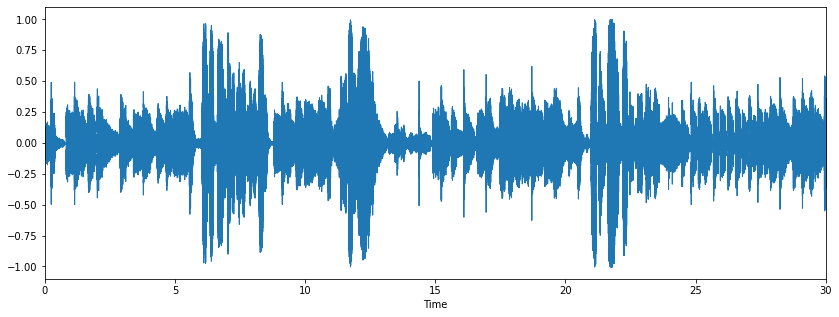

In [ ]:
# визуализация аудиосигнала средствами librosa

plt.figure(figsize=(14, 5))
librosa.display.waveplot(ts1, sr=sr1)

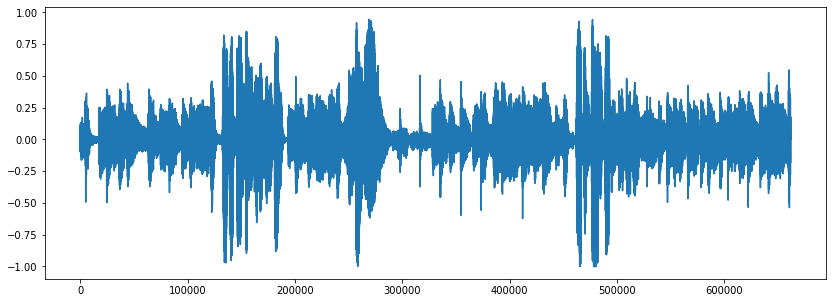

In [ ]:
# визуализация аудиосигнала средствами matplotlib

plt.figure(figsize=(14, 5))
plt.plot(ts1)
plt.grid(which = 'minor',
        color = 'gray',
        linestyle=':')
plt.show()

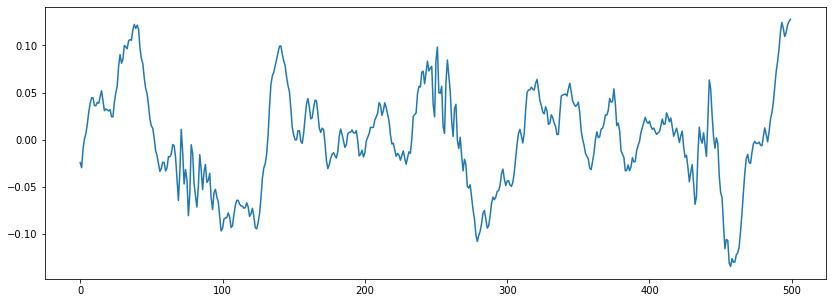

In [ ]:
# тот же график, но короткий отрезок

plt.figure(figsize=(14, 5))
plt.plot(ts1[:500])
plt.grid(which = 'minor',
        color = 'gray',
        linestyle=':')
plt.show()

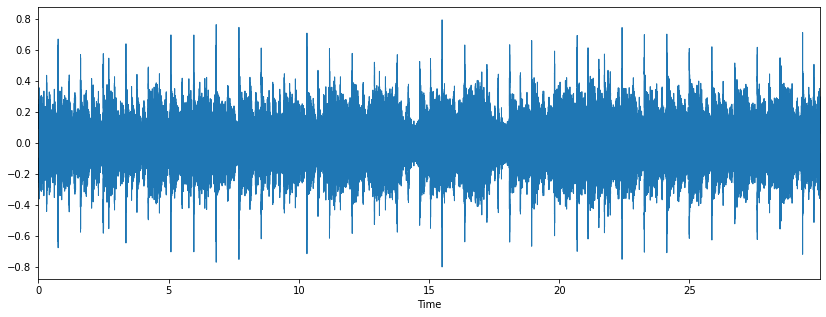

In [ ]:
# визуализация аудиосигнала средствами librosa трека жанра metal

plt.figure(figsize=(14, 5))
librosa.display.waveplot(ts2, sr=sr2)

Видим, что в зависимости от жанра форма и частота графического изображения звуковой волны существенно меняется. Однако в таком виде цифровое представление звуковой волны не получится использовать в качестве признаков. Выделим из нее некоторые другие параметры.

### Получение и отбор признаков из аудиотрека

Для звука существует достаточно много параметров, которые можно представить в цифровом виде и использовать в качестве признаков для обучения моделей.


#### Темп

Темп - широко известный параметр, определяющий как часто в композиции встречаются биты. Часто для композиций определенных жанров характерен темп определенного диапазона значений, но не всегда. Некоторые жанры схожи по темпу или близки.

In [ ]:
tempo1, beat_frames1 = librosa.beat.beat_track(y=ts1, sr=sr1)
tempo2, beat_frames2 = librosa.beat.beat_track(y=ts2, sr=sr2)

print(tempo1, tempo2)
print(beat_frames1, beat_frames2)

69.83741554054055 135.99917763157896
[  11   49   87  126  163  202  240  275  318  356  393  431  469  504
  546  583  620  656  694  731  769  806  843  882  919  957  995 1032
 1070 1107 1143 1180 1216 1254] [  14   33   52   70   89  107  126  145  164  182  201  219  238  257
  276  295  314  332  351  369  388  407  426  445  463  482  500  519
  538  556  575  593  612  631  649  668  687  706  724  742  761  780
  798  817  836  854  872  891  910  928  947  966  984 1003 1022 1040
 1059 1077 1096 1115 1133 1152 1171 1189 1208 1227 1246 1264]


#### Мел-кепстральные коэффициенты


Обычно представляют в виде тепловой карты

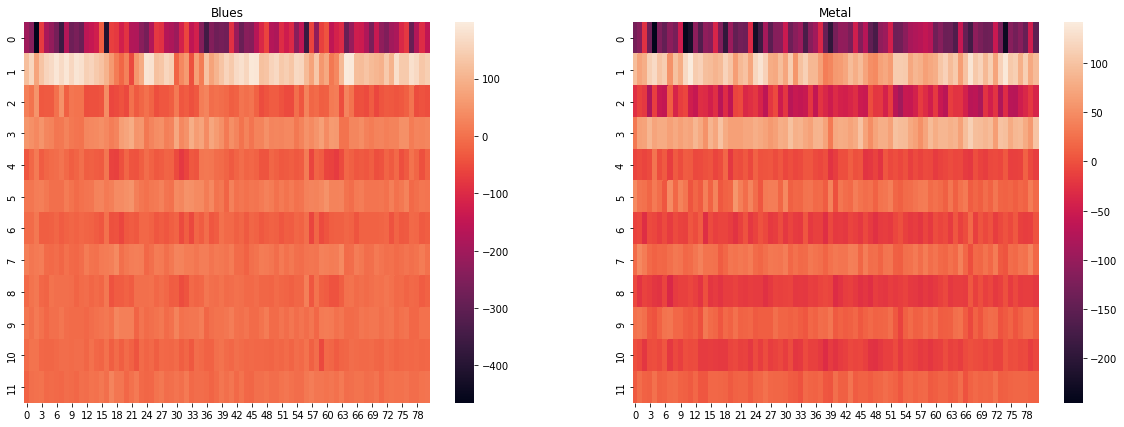

In [ ]:
mfcc1 = librosa.feature.mfcc(y=ts1, sr=sr1, hop_length=8192, n_mfcc=12)

mfcc2 = librosa.feature.mfcc(y=ts2, sr=sr2, hop_length=8192, n_mfcc=12)

plt.figure(figsize=(20, 7))

plt.subplot('121')
sns.heatmap(mfcc1)
plt.title('Blues')

plt.subplot('122')
sns.heatmap(mfcc2)
plt.title('Metal')

plt.show()


In [ ]:
mfcc1.shape

(12, 81)

Поскольку мел-кепстральные коэффициенты представляют собой матрицу, будем использовать в качестве признаков исредненные значения каждой строки

In [ ]:
for n in mfcc1:
    print(np.mean(n))

-182.08086
120.25228
-20.119165
35.873455
-26.382809
14.498792
-24.390213
6.4123106
-11.785518
1.7592036
-12.971818
-1.355392


#### Цветность

Цветность передает распределение энергии в определенном высотном классе

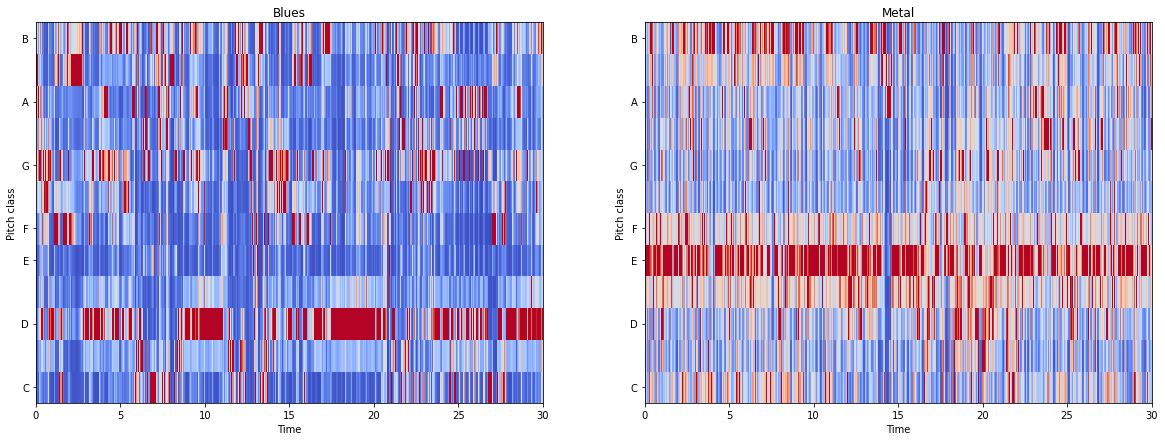

In [ ]:
hop_length = 512

chromagram1 = librosa.feature.chroma_stft(ts1, sr=sr1, hop_length=hop_length)
chromagram2 = librosa.feature.chroma_stft(ts2, sr=sr2, hop_length=hop_length)

plt.figure(figsize=(20, 7))

plt.subplot('121')
librosa.display.specshow(chromagram1, sr=sr1, x_axis='time', y_axis='chroma',
                         hop_length=hop_length, cmap='coolwarm')
plt.title('Blues')

plt.subplot('122')
librosa.display.specshow(chromagram2, sr=sr2, x_axis='time', y_axis='chroma',
                         hop_length=hop_length, cmap='coolwarm')
plt.title('Metal')

plt.show()


In [ ]:
chromagram1.shape

(12, 1293)

Также как и мел-кепстральные коэффициенты цветность в виде матрицы использовать неудобно, придется делать усреднение для каждой тональности

In [ ]:
np.mean(chromagram1, axis=1)

array([0.23830429, 0.30020088, 0.61701083, 0.23565836, 0.12397125,
       0.24369822, 0.27947593, 0.41117647, 0.24383795, 0.28538796,
       0.2843709 , 0.3663821 ], dtype=float32)

In [ ]:
np.mean(chromagram2, axis=1)

array([0.42060727, 0.35282147, 0.43866453, 0.587991  , 0.80861074,
       0.540372  , 0.33629918, 0.3681703 , 0.4002474 , 0.38018045,
       0.42558506, 0.5268954 ], dtype=float32)

#### Спектральный центроид

Спектральный центроид - указывает на какой части частотного спектра сосредоточена основная энергия.

In [ ]:
# спектральный центроид
spectral_centroids1 = librosa.feature.spectral_centroid(ts1, sr=sr1)[0]
spectral_centroids2 = librosa.feature.spectral_centroid(ts2, sr=sr2)[0]
print(spectral_centroids1.shape)
print(spectral_centroids1)
print(np.mean(spectral_centroids1))
print(np.mean(spectral_centroids2))

(1293,)
[1740.05154963 1814.0745392  1869.88756628 ... 2627.96091407 2239.42979065
 1865.41728255]
1831.993939606849
2384.552716223428


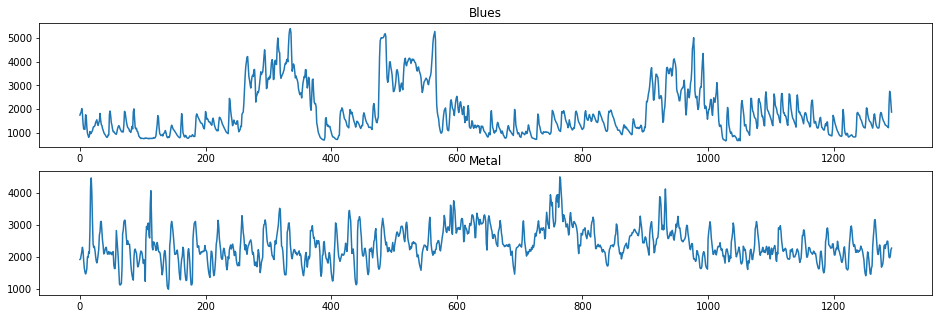

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot('211')
plt.plot(spectral_centroids1)
plt.title('Blues')

plt.subplot('212')
plt.plot(spectral_centroids2)
plt.title('Metal');

Использовать весь вектор спектрального центроида неэффективно, поэтому разобьем трек на 6 частей и сделаем усреднение отдельно для каждой части. Таким образом получится набор из 6 усредненных спектральных центроидов.

#### Пересечения нуля

Характеристика гладкости сигнала. В качестве признака будем использовать долю семплов с пересечениями в общем количестве.

In [ ]:
print('Blues')

print(np.mean(librosa.feature.zero_crossing_rate(ts1)))

print('Metal')

np.mean(librosa.feature.zero_crossing_rate(ts2))

Blues
0.09404153373936582
Metal


0.12607323690061872

### Выделение отобранных признаков из датасета

Напишем функцию, которая выделит набор признаков из трека

In [ ]:
def get_features(ts, sr):
    
    tempo = librosa.beat.beat_track(y=ts, sr=sr)[0] # темп
    zero_crossing = np.mean(librosa.feature.zero_crossing_rate(ts))  # пересечения с нулем
    chroma_stfts = librosa.feature.chroma_stft(y=ts, sr=sr) # цветность
    spec_centroid = librosa.feature.spectral_centroid(y=ts, sr=sr)[0] # спектральный центроид
    spec_centroids = []
    for i in range(len(spec_centroid) // 200):
        spec_centroids.append(np.mean(spec_centroid[(i*200):((i+1)*200)]))
    mfccs = librosa.feature.mfcc(y=ts, sr=sr, hop_length=8192, n_mfcc=12) # мел-кепстральные коэффициенты
    
    out = np.array(tempo)
    out = np.append(out, zero_crossing)
    out = np.append(out, np.array(spec_centroids))
    out = np.append(out, np.mean(chroma_stfts, axis=1))
    out = np.append(out, np.mean(mfccs, axis=1))
    
    return out

In [ ]:
X = []
y = []

for genre in genres:
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        ts, sr = librosa.load(songname, mono=True, duration=30)
        out = get_features(ts, sr)
        
        X.append(out)
        y.append(genres.index(genre))
        
    print("Жанр", g, 'готов')
    
X = np.array(X)
y = np.array(y)

Жанр reggae готов
Жанр jazz готов
Жанр country готов
Жанр hiphop готов
Жанр rock готов
Жанр metal готов
Жанр classical готов
Жанр disco готов
Жанр blues готов
Жанр pop готов


Получили набор признаков. Посмотрим размер и структуру данных

In [ ]:
X.shape

(1000, 32)

In [ ]:
y.shape

(1000,)

In [ ]:
X[98:102]


array([[ 8.91029095e+01,  5.91477905e-02,  1.65280109e+03,
         1.43700502e+03,  1.54947143e+03,  1.60932320e+03,
         1.74645692e+03,  1.83449623e+03,  4.26146716e-01,
         4.20458198e-01,  4.95491773e-01,  6.31510615e-01,
         5.03113091e-01,  4.36457217e-01,  3.27378631e-01,
         4.22882378e-01,  4.19953376e-01,  3.75928730e-01,
         4.82620567e-01,  4.17603821e-01, -2.49072067e+02,
         1.15437355e+02,  7.24697256e+00,  4.42967186e+01,
        -5.35368872e+00,  3.68564453e+01, -2.53262734e+00,
         2.42393265e+01, -1.24382725e+01,  1.31018801e+01,
        -4.28157330e+00,  1.06825609e+01],
       [ 1.51999081e+02,  7.23423441e-02,  1.93386094e+03,
         2.03526524e+03,  2.02464432e+03,  2.05790396e+03,
         2.17029357e+03,  2.07565213e+03,  4.59520042e-01,
         5.34957647e-01,  4.69867378e-01,  4.15463954e-01,
         4.53193486e-01,  4.03057843e-01,  3.85408252e-01,
         3.72797996e-01,  4.56230551e-01,  5.54710031e-01,
         4.71

Проведем разделение на обучающую и тестовую выборку

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1982, shuffle=True)

Проведем стандартизацию данных

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 32)
(900,)
(100, 32)
(100,)


### Построение и обучение нейронной сети

Построим полносвязную нейронную сеть и обучим ее

In [ ]:
set_random_seed(1982)

model = Sequential()
model.add(Dense(64, activation='elu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='SGD',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs=300,
                   batch_size=16,
                   validation_data=(X_test, y_test),
                   verbose=1)



Epoch 1/300
57/57 [==============================] - 1s 7ms/step - loss: 2.1497 - accuracy: 0.2122 - val_loss: 1.9244 - val_accuracy: 0.2600
Epoch 2/300
57/57 [==============================] - 0s 3ms/step - loss: 1.8768 - accuracy: 0.3067 - val_loss: 1.7886 - val_accuracy: 0.3100
Epoch 3/300
57/57 [==============================] - 0s 3ms/step - loss: 1.7702 - accuracy: 0.3278 - val_loss: 1.6956 - val_accuracy: 0.3800
Epoch 4/300
57/57 [==============================] - 0s 3ms/step - loss: 1.7014 - accuracy: 0.3711 - val_loss: 1.6300 - val_accuracy: 0.4100
Epoch 5/300
57/57 [==============================] - 0s 4ms/step - loss: 1.6082 - accuracy: 0.4022 - val_loss: 1.5960 - val_accuracy: 0.3800
Epoch 6/300
57/57 [==============================] - 0s 3ms/step - loss: 1.5327 - accuracy: 0.4256 - val_loss: 1.5513 - val_accuracy: 0.4500
Epoch 7/300
57/57 [==============================] - 0s 4ms/step - loss: 1.5484 - accuracy: 0.4200 - val_loss: 1.5123 - val_accuracy: 0.4600
Epoch 8/300
5

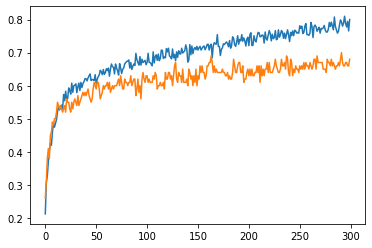

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)
print('test loss, test acc:', results)

2/2 [==============================] - 0s 7ms/step - loss: 1.1553 - accuracy: 0.6800
test loss, test acc: [1.155348539352417, 0.6800000071525574]


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                2112      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               16512     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)               

После 400 эпох получаем значения метрики accuracy:
- на обучающей - 0,80
- на тестовой - 0,68


В данном случае нейросеть очень сильно переобучалась, что может быть объяснено малым размером обучающего датасета. Для минимизации переобучения в нейросеть добавлены слои регуляризации.

Для сравнения обучим также ансамблевую модель Random Forest и протестируем.

In [ ]:
model = RandomForestClassifier(random_state=1982)
depth_range = list(range(1, 101))
est_range = list(range(1, 501))
params = {'max_depth': depth_range, 'n_estimators': est_range}
model1 = RandomizedSearchCV(model, params, verbose=3, n_iter=20, scoring='accuracy', random_state=1982)
model1.fit(X_train, y_train)
best_params = model1.best_params_
best_params

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....max_depth=8, n_estimators=170;, score=0.572 total time=   0.7s
[CV 2/5] END .....max_depth=8, n_estimators=170;, score=0.567 total time=   0.6s
[CV 3/5] END .....max_depth=8, n_estimators=170;, score=0.594 total time=   0.6s
[CV 4/5] END .....max_depth=8, n_estimators=170;, score=0.606 total time=   0.6s
[CV 5/5] END .....max_depth=8, n_estimators=170;, score=0.600 total time=   0.6s
[CV 1/5] END ....max_depth=49, n_estimators=305;, score=0.589 total time=   1.2s
[CV 2/5] END ....max_depth=49, n_estimators=305;, score=0.606 total time=   1.2s
[CV 3/5] END ....max_depth=49, n_estimators=305;, score=0.600 total time=   1.2s
[CV 4/5] END ....max_depth=49, n_estimators=305;, score=0.606 total time=   1.2s
[CV 5/5] END ....max_depth=49, n_estimators=305;, score=0.583 total time=   1.2s
[CV 1/5] END .....max_depth=60, n_estimators=25;, score=0.539 total time=   0.1s
[CV 2/5] END .....max_depth=60, n_estimators=25

{'n_estimators': 391, 'max_depth': 55}

In [ ]:
model = RandomForestClassifier(**best_params, random_state=1982)
model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test, pred)


0.61

В ходе тестирования ансамблевой модели получен результат метрики accuracy - 0,61

### Вывод

1. Используя возможности библиотеки librosa, из звукового файла несложно выделить признаки, которые возможно использовать для обучения моделей. Также данная библиотека имеет встроенные средства для визуализации и прослушивания аудио.

2. Решая задачу мультиклассовой классификации на 10 классов, на датасете из 1000 треков (по 100 на класс) получен результат на тестовой выборке: 
accuracy = 0,68

3. Модели очень легко переобучаются, что может быть связано с малым размером датасета. 

4. Многие признаки представлены в виде матриц данных, которые приходится усреднять. Для работы с ними в неизменном виде возможно стоит попробовать использовать сверточные нейронные сети.